In [1]:
# 量子数値積分を量子回路で構築するためのソースコード
# 必要なモジュールをインポート
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.tools.visualization import plot_histogram

In [2]:
# 量子レジスタを設定する。
qr_amp = QuantumRegister(3, name='amp')
qr_qft = QuantumRegister(3, name='qft')
c = ClassicalRegister(3, name='x')
# 量子回路を生成する。
circuit = QuantumCircuit(qr_amp, qr_qft, c)

In [3]:
def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta/2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta/2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

In [4]:
# 振幅増幅関数
def cq(circuit, amp, c):
    sub_q = QuantumRegister(4)
    circ = QuantumCircuit(sub_q, name='$C\mathcal{Q}$')
    circ.cz(3, 2)

    ccry(circ, 1, sub_q[1], 3, sub_q[2])
    ccry(circ, 1/2, sub_q[0], 3, sub_q[2])
    circ.cry(-np.pi, 3, sub_q[2])

    circ.ch(3, 1)
    circ.ch(3, 0)

    circ.cx(3, 0)
    circ.cx(3, 1)
    circ.cx(3, 2)

    circ.ch(3, 2)
    circ.mct([3, 0, 1], 2)
    circ.ch(3, 2)

    circ.cx(3, 2)
    circ.cx(3, 1)
    circ.cx(3, 0)

    circ.ch(3, 0)
    circ.ch(3, 1)

    circ.cry(np.pi, 3, sub_q[2])
    ccry(circ, -1/2, sub_q[0], 3, sub_q[2])
    ccry(circ, -1, sub_q[1], 3, sub_q[2])

    sub_inst = circ.to_instruction()
    circuit.append(sub_inst, [amp[0], amp[1], amp[2], c])

In [5]:
# P
circuit.h([0,1,3,4,5])

circuit.barrier(qr_amp)

# R
circuit.ry(np.pi, 2)
circuit.cry(-1/2, qr_amp[0], qr_amp[2])
circuit.cry(-1, qr_amp[1], qr_amp[2])
# 振幅増幅
cq(circuit, qr_amp, 3)

for i in range(2):
    cq(circuit, qr_amp, 4)

for i in range(4):
    cq(circuit, qr_amp, 5)


# 逆量子フーリエ変換
circuit.swap(3,5)
circuit.h(3)
circuit.cp(-np.pi/2,3,4)
circuit.h(4)
circuit.cp(-np.pi/4,3,5)
circuit.cp(-np.pi/2,4,5)
circuit.h(5)

circuit.barrier(qr_qft)
# 測定する。
circuit.measure(qr_qft, c)

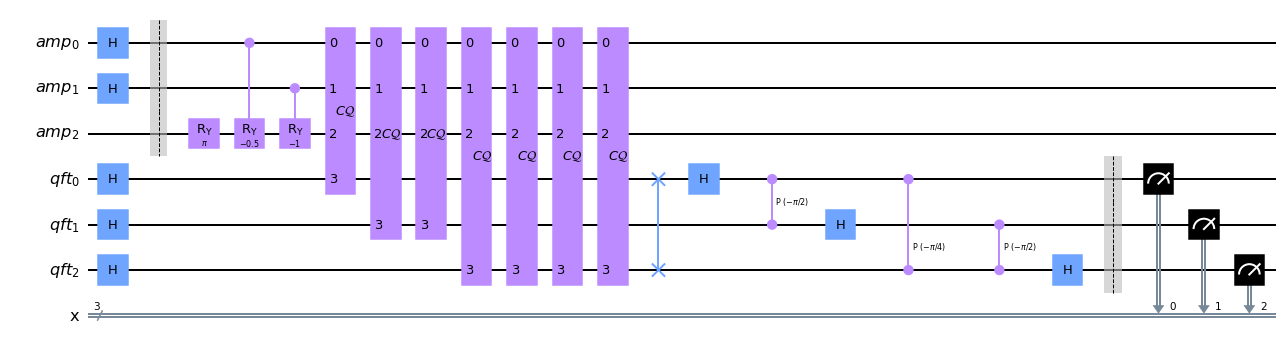

In [6]:
circuit.draw(output='mpl', fold=50)

{'101': 6, '100': 5, '001': 495, '110': 11, '010': 13, '000': 17, '011': 3, '111': 474}


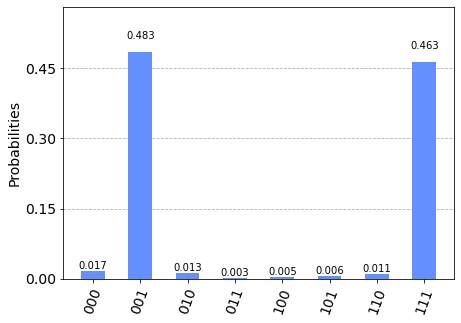

In [7]:
# マシンを選択して実行する。
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
#　実行結果を出力＆プロットする。
print(answer) 
plot_histogram(answer)

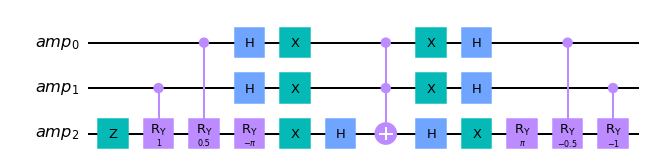

In [9]:
qr_amp = QuantumRegister(3, name='amp')
circuit = QuantumCircuit(qr_amp)

def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta/2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta/2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

# 振幅増幅
circuit.z(2)

circuit.cry(1, 1, 2)
circuit.cry(1/2, 0, 2)
circuit.ry(-np.pi, 2)
circuit.h([0, 1])

circuit.x([0, 1, 2])
circuit.h(2)
circuit.ccx(0, 1, 2)
circuit.h(2)
circuit.x([2, 1, 0])

circuit.h([0, 1])
circuit.ry(np.pi, 2)
circuit.cry(-1/2, 0, 2)
circuit.cry(-1, 1, 2)

circuit.draw(output='mpl', fold=50)